In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import catboost as cat
from sklearn import linear_model as lm
from sklearn.preprocessing import SplineTransformer, OneHotEncoder, StandardScaler
from sklearn.metrics import mean_squared_error


# Séries Temporais
No contexto de análise e ciência de dados, séries temporais são dados observados de forma sequencial, em intervalos regulares ou irregulares. Muitas vezes esses dados são resultado de agregações feitas por um campo de data: podemos construir a série temporal do número de itens vendidos pelo Olist por dia, ou então o número de ataques de tubarão for mês.

# Dataset

Vamos continuar a análise do conjunto de dados de cancelamentos de reservas em 2 hotéis europeus. No entanto, enquanto no case de sábado passado fizemos uma análise baseada no dado transacional (cada individuo de nossa tabela era uma reserva) hoje agregaremos este dado e analisaremos o resultado agregado diário para um dos hotéis.

Primeiro vamos carregar o conjunto de dados de hotéis e transformar a informação de data em campos datetime. Isso nos permitirá calcular a data na qual a reserva foi feita.

In [4]:
tb_hotel = pd.read_csv("data/tb_hotel_bookings_full.csv")
tb_hotel["arrival_dt"] = pd.to_datetime(tb_hotel["arrival_date"])
tb_hotel["update_dt"] = pd.to_datetime(tb_hotel["reservation_status_date"])
tb_hotel["reserva_dt"] = tb_hotel["arrival_dt"] - pd.to_timedelta(
    tb_hotel["lead_time"], unit="d"
)


Para construir a série temporal de cancelamentos e reservas precisamos decidir por qual campo de data agregaremos nossos dados:

1. **Data de Chegada**
1. **Data da Reserva**
1. **Data da Última Atualização da Reserva**

Essa opção é algo comum quando construímos séries temporais (no âmbito de produtos por exemplo podemos ver as datas de compra, de faturamento e de entrega por exemplo). Por enquanto limitaremos a análise à **data de chegada**.

In [5]:
tb_resort = tb_hotel[tb_hotel["hotel"] == "Resort Hotel"]
tb_resort_ts = (
    tb_resort.groupby("arrival_dt")
    .agg(
        num_reservas=pd.NamedAgg("id_booking", "count"),
        num_canceladas=pd.NamedAgg("is_canceled", "sum"),
    )
    .reset_index()
)
tb_resort_ts["per_canceladas"] = (
    tb_resort_ts["num_canceladas"] / tb_resort_ts["num_reservas"]
)


In [7]:
tb_resort_ts

,arrival_dt,num_reservas,num_canceladas,per_canceladas
0,2015-07-01,43,5,0.116279
1,2015-07-02,44,9,0.204545
2,2015-07-03,40,13,0.325000
3,2015-07-04,50,14,0.280000
4,2015-07-05,45,8,0.177778
...,...,...,...,...
788,2017-08-27,67,21,0.313433
789,2017-08-28,78,37,0.474359
790,2017-08-29,35,14,0.400000
791,2017-08-30,42,14,0.333333


A forma mais comum de visualizar dados de série temporal é através de **lineplots** onde o tempo é colocado no eixo X e as variáveis a serem analisadas no eixo Y.

Text(0.5, 0.95, 'Evolução de Reservas por Data de Chegada')

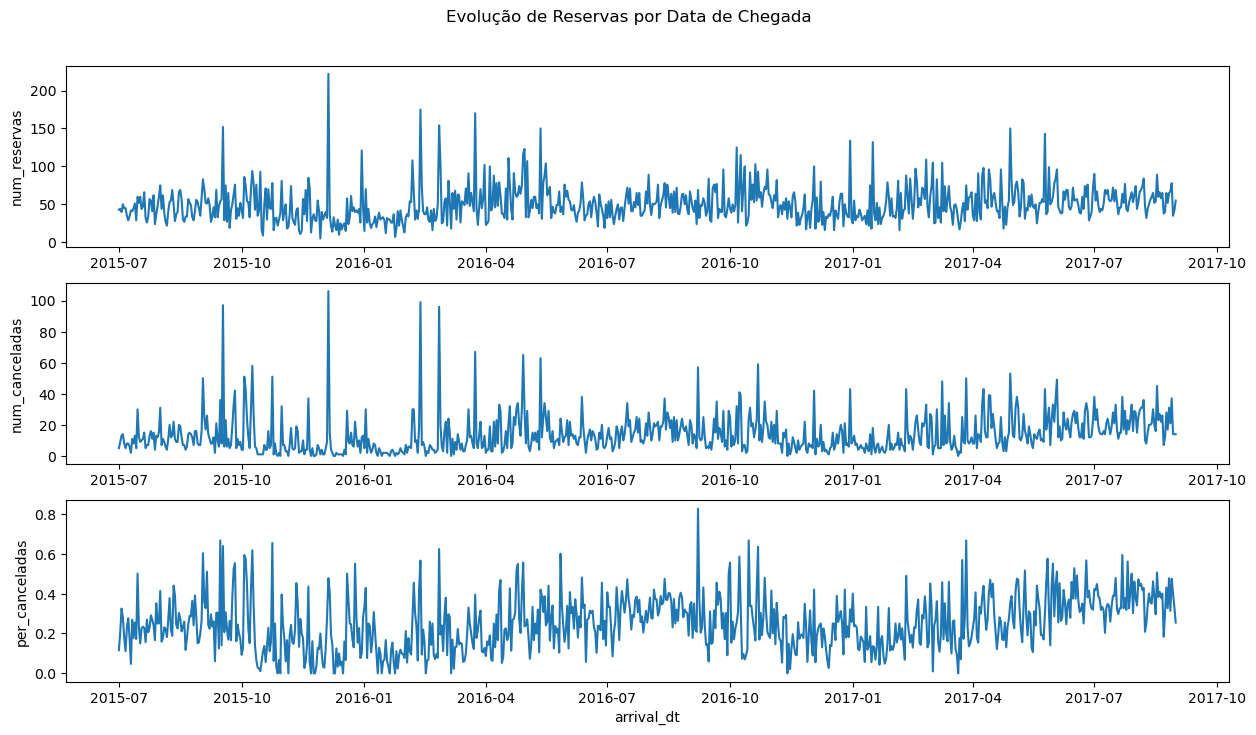

In [6]:
fig, ax = plt.subplots(3, 1, figsize=(15, 8))
sns.lineplot(data=tb_resort_ts, x="arrival_dt", y="num_reservas", ax=ax[0])
sns.lineplot(data=tb_resort_ts, x="arrival_dt", y="num_canceladas", ax=ax[1])
sns.lineplot(data=tb_resort_ts, x="arrival_dt", y="per_canceladas", ax=ax[2])
ax[0].set_xlabel("")
ax[1].set_xlabel("")
fig.suptitle("Evolução de Reservas por Data de Chegada", y=0.95)


## Train & Test para séries temporais
A nossa estratégia tradicional para divisão de um dataset em train e test não funciona em séries temporais: como elas são definidas pela sequencialidade das observações, remover pontos aleatórios de dentro da série seria estranho... A forma mais simples e tradicional de se fazer essa divisão é selecionando pontos no fim da série como nosso conjunto teste. No exemplo acima optei por formar o conjunto de train a partir dos dois primeiros anos continuos que temos na série (veremos porque quando olharmos componentes sazonais).

In [8]:
tb_resort_ts["arrival_dt"].describe()


count                    793
mean     2016-07-31 00:00:00
min      2015-07-01 00:00:00
25%      2016-01-15 00:00:00
50%      2016-07-31 00:00:00
75%      2017-02-14 00:00:00
max      2017-08-31 00:00:00
Name: arrival_dt, dtype: object

Ao invés de realizar a transformação agora, vamos definir uma função que realiza essa divisão para nós. Dessa forma não precisamos replicar nosso feature engineering em 2 datasets o tempo todo.

In [9]:
def split_hotel_ts(hotel_data, break_date):
    train_data = hotel_data[hotel_data["arrival_dt"] < break_date].copy()
    test_data = hotel_data[hotel_data["arrival_dt"] >= break_date].copy()
    return train_data, test_data


# Decomposição TCSI

A forma mais tradicional de se analisar um série temporal é através da decomposição TCSI:

1. **T - Componente de Tendência (Trend):** representação da evolução a longo prazo da série (*a taxa de cancelamento está crescendo ou caindo?*)
1. **C - Componente Ciclico (Cyclic)** representação da evolução ciclica não periódicas (*tivemos momentos com mais (ou menos) cancelamentos de forma estrutural?*)
1. **S - Componente Sazonal (Seasonal)** representação da peridiocidade sazonal (ciclo regular) (*temos mais cancelamento para reservas em junho? ou para reservas de segunda-feira? ou da última semana do mês?*)
1. **I - Componente de Ruído (Irregular/Noise)** o que não é representado pelos três componentes acima.

In [11]:
tb_resort_ts[["arrival_dt", "per_canceladas"]]

,arrival_dt,per_canceladas
0,2015-07-01,0.116279
1,2015-07-02,0.204545
2,2015-07-03,0.325000
3,2015-07-04,0.280000
4,2015-07-05,0.177778
...,...,...
788,2017-08-27,0.313433
789,2017-08-28,0.474359
790,2017-08-29,0.400000
791,2017-08-30,0.333333


## Componente de Tendência (Trend)

In [13]:
tb_resort_ts["t_dias"] = (
    tb_resort_ts["arrival_dt"] - min(tb_resort_ts["arrival_dt"])
).dt.total_seconds() / (24 * 60 * 60)
tb_resort_ts.head()

,arrival_dt,num_reservas,num_canceladas,per_canceladas,t_dias
0,2015-07-01,43,5,0.116279,0.0
1,2015-07-02,44,9,0.204545,1.0
2,2015-07-03,40,13,0.325000,2.0
3,2015-07-04,50,14,0.280000,3.0
4,2015-07-05,45,8,0.177778,4.0


In [14]:
tb_resort_ts.tail()

,arrival_dt,num_reservas,num_canceladas,per_canceladas,t_dias
788,2017-08-27,67,21,0.313433,788.0
789,2017-08-28,78,37,0.474359,789.0
790,2017-08-29,35,14,0.400000,790.0
791,2017-08-30,42,14,0.333333,791.0
792,2017-08-31,55,14,0.254545,792.0


### Estimativa de tendência linear

In [15]:
train_data, test_data = split_hotel_ts(tb_resort_ts, "2017-08-01")

In [16]:
trend_fit = lm.LinearRegression()
trend_fit.fit(train_data[["t_dias"]], train_data["per_canceladas"])


LinearRegression()

In [18]:
tb_resort_ts["pred_trend_linear"] = trend_fit.predict(tb_resort_ts[["t_dias"]])


Text(0.5, 0.95, 'Evolução de Reservas por Data de Chegada')

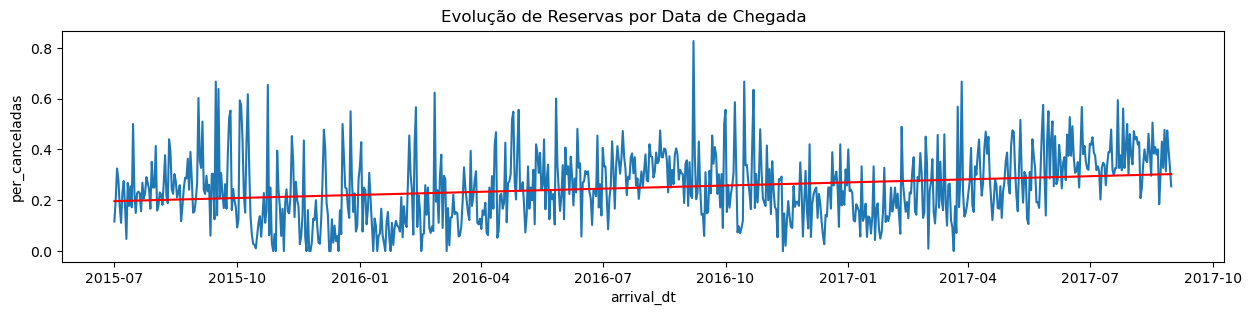

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(15, 3))
sns.lineplot(data=tb_resort_ts, x="arrival_dt", y="per_canceladas")
sns.lineplot(data=tb_resort_ts, x="arrival_dt", y="pred_trend_linear", color="red")
fig.suptitle("Evolução de Reservas por Data de Chegada", y=0.95)


## Componente Cíclico (Cycle)

Como os ciclos representam variações não-periódicas é dificil separa-los da avaliação de tendência (principalmente em séries curtas). Vamos utilizar três técnicas para estimar variações em relação a tendência.

### Tendência Polinomial

In [24]:
from sklearn.preprocessing import PolynomialFeatures


In [25]:
poly_trans = PolynomialFeatures(degree=2)
poly_trans.fit(train_data[["t_dias"]])


PolynomialFeatures()

In [26]:
poly_trans.n_output_features_


3

In [27]:
tb_resort_ts

,arrival_dt,num_reservas,num_canceladas,per_canceladas,t_dias,pred_trend_linear
0,2015-07-01,43,5,0.116279,0.0,0.196375
1,2015-07-02,44,9,0.204545,1.0,0.196509
2,2015-07-03,40,13,0.325000,2.0,0.196644
3,2015-07-04,50,14,0.280000,3.0,0.196778
4,2015-07-05,45,8,0.177778,4.0,0.196912
...,...,...,...,...,...,...
788,2017-08-27,67,21,0.313433,788.0,0.302185
789,2017-08-28,78,37,0.474359,789.0,0.302319
790,2017-08-29,35,14,0.400000,790.0,0.302453
791,2017-08-30,42,14,0.333333,791.0,0.302588


In [29]:
poly_trans.transform(tb_resort_ts[["t_dias"]])

array([[1.00000e+00, 0.00000e+00, 0.00000e+00],
       [1.00000e+00, 1.00000e+00, 1.00000e+00],
       [1.00000e+00, 2.00000e+00, 4.00000e+00],
       ...,
       [1.00000e+00, 7.90000e+02, 6.24100e+05],
       [1.00000e+00, 7.91000e+02, 6.25681e+05],
       [1.00000e+00, 7.92000e+02, 6.27264e+05]])

In [28]:
poly_names = ["P" + str(i) for i in range(poly_trans.n_output_features_)]
pd.DataFrame(
    poly_trans.transform(tb_resort_ts[["t_dias"]]),
    columns=poly_names,
)


,P0,P1,P2
0,1.0,0.0,0.0
1,1.0,1.0,1.0
2,1.0,2.0,4.0
3,1.0,3.0,9.0
4,1.0,4.0,16.0
...,...,...,...
788,1.0,788.0,620944.0
789,1.0,789.0,622521.0
790,1.0,790.0,624100.0
791,1.0,791.0,625681.0


In [30]:
poly_trans.transform(tb_resort_ts[["t_dias"]])

array([[1.00000e+00, 0.00000e+00, 0.00000e+00],
       [1.00000e+00, 1.00000e+00, 1.00000e+00],
       [1.00000e+00, 2.00000e+00, 4.00000e+00],
       ...,
       [1.00000e+00, 7.90000e+02, 6.24100e+05],
       [1.00000e+00, 7.91000e+02, 6.25681e+05],
       [1.00000e+00, 7.92000e+02, 6.27264e+05]])

In [31]:
poly_names = ["P" + str(i) for i in range(poly_trans.n_output_features_)]
tb_resort_ts_p = pd.concat(
    [
        tb_resort_ts,
        pd.DataFrame(
            poly_trans.transform(tb_resort_ts[["t_dias"]]),
            columns=poly_names,
        ),
    ],
    axis=1,
)
tb_resort_ts_p.head()


,arrival_dt,num_reservas,num_canceladas,per_canceladas,t_dias,pred_trend_linear,P0,P1,P2
0,2015-07-01,43,5,0.116279,0.0,0.196375,1.0,0.0,0.0
1,2015-07-02,44,9,0.204545,1.0,0.196509,1.0,1.0,1.0
2,2015-07-03,40,13,0.325000,2.0,0.196644,1.0,2.0,4.0
3,2015-07-04,50,14,0.280000,3.0,0.196778,1.0,3.0,9.0
4,2015-07-05,45,8,0.177778,4.0,0.196912,1.0,4.0,16.0


Text(0.5, 1.05, 'Evolução da Taxa de Cancelamentos\ncom Tendências Linear e Polinomial de grau 2')

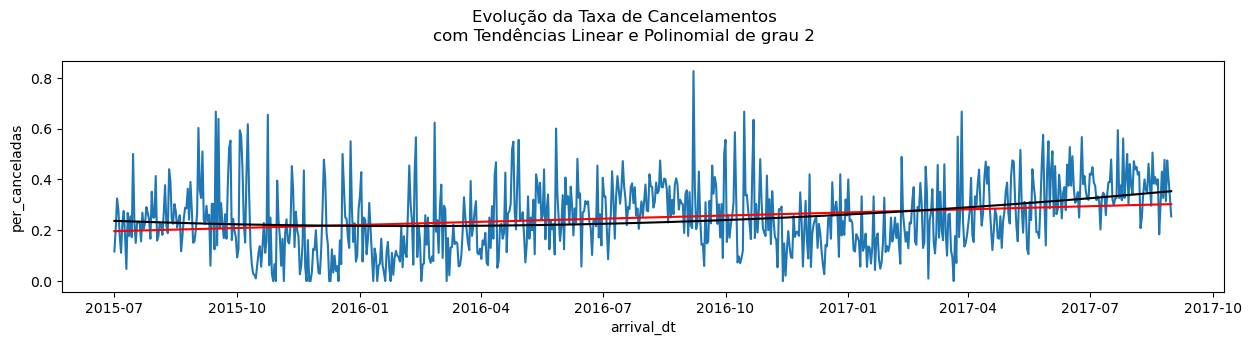

In [32]:
train_data, test_data = split_hotel_ts(tb_resort_ts_p, "2017-08-01")

poly_trend_fit = lm.LinearRegression()
poly_trend_fit.fit(train_data[poly_names], train_data["per_canceladas"])


tb_resort_ts_p["pred_trend_poly"] = poly_trend_fit.predict(tb_resort_ts_p[poly_names])

fig, ax = plt.subplots(1, 1, figsize=(15, 3))
sns.lineplot(data=tb_resort_ts_p, x="arrival_dt", y="per_canceladas")
sns.lineplot(data=tb_resort_ts_p, x="arrival_dt", y="pred_trend_linear", color="red")
sns.lineplot(data=tb_resort_ts_p, x="arrival_dt", y="pred_trend_poly", color="black")
fig.suptitle(
    f"Evolução da Taxa de Cancelamentos\ncom Tendências Linear e Polinomial de grau {poly_trans.degree}",
    y=1.05,
)


In [33]:
test_data["pred_trend_linear"] = trend_fit.predict(test_data[["t_dias"]])
test_data["pred_trend_poly"] = poly_trend_fit.predict(test_data[poly_names])
rmse_lin = np.sqrt(
    mean_squared_error(test_data["per_canceladas"], test_data["pred_trend_linear"])
)
rmse_poly = np.sqrt(
    mean_squared_error(test_data["per_canceladas"], test_data["pred_trend_poly"])
)
print(f"Trend Lin.: {round(rmse_lin, 2)}")
print(f"Trend Poly.: {round(rmse_poly, 2)}")


Trend Lin.: 0.11
Trend Poly.: 0.08


### B-Splines

In [57]:
spl_trans = SplineTransformer(n_knots=12, extrapolation="constant")
spl_trans.fit(train_data[["t_dias"]])

spl_names = ["S" + str(i) for i in range(spl_trans.n_features_out_)]
tb_resort_ts_b = pd.concat(
    [
        tb_resort_ts,
        pd.DataFrame(
            spl_trans.transform(tb_resort_ts[["t_dias"]]),
            columns=spl_names,
        ),
    ],
    axis=1,
)
tb_resort_ts_b.head()


,arrival_dt,num_reservas,num_canceladas,per_canceladas,t_dias,pred_trend_linear,S0,S1,S2,S3,S4,S5,S6,S7,S8,S9,S10,S11,S12,S13
0,2015-07-01,43,5,0.116279,0.0,0.196375,0.166667,0.666667,0.166667,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2015-07-02,44,9,0.204545,1.0,0.196509,0.159543,0.666459,0.173997,5.033532e-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2015-07-03,40,13,0.325000,2.0,0.196644,0.152626,0.665843,0.181527,4.026826e-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2015-07-04,50,14,0.280000,3.0,0.196778,0.145911,0.664827,0.189248,1.359054e-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2015-07-05,45,8,0.177778,4.0,0.196912,0.139397,0.663420,0.197151,3.221460e-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<Axes: xlabel='t_dias', ylabel='S0'>

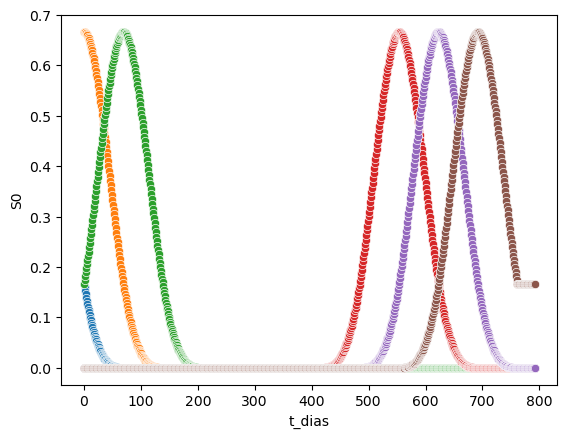

In [58]:
sns.scatterplot(data=tb_resort_ts_b, x="t_dias", y="S0")
sns.scatterplot(data=tb_resort_ts_b, x="t_dias", y="S1")
sns.scatterplot(data=tb_resort_ts_b, x="t_dias", y="S2")

sns.scatterplot(data=tb_resort_ts_b, x="t_dias", y="S9")
sns.scatterplot(data=tb_resort_ts_b, x="t_dias", y="S10")
sns.scatterplot(data=tb_resort_ts_b, x="t_dias", y="S11")


Text(0.5, 1.05, 'Evolução da Taxa de Cancelamentos\ncom Tendências Linear e de Splines')

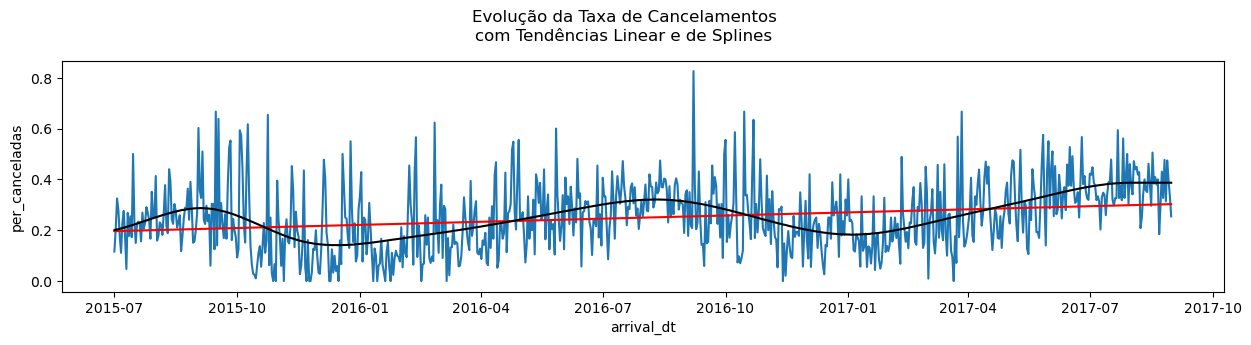

In [59]:
train_data, test_data = split_hotel_ts(tb_resort_ts_b, "2017-08-01")

spline_fit = lm.LinearRegression()
spline_fit.fit(train_data[spl_names], train_data["per_canceladas"])
tb_resort_ts_b["pred_spline"] = spline_fit.predict(tb_resort_ts_b[spl_names])

fig, ax = plt.subplots(1, 1, figsize=(15, 3))
sns.lineplot(data=tb_resort_ts_b, x="arrival_dt", y="per_canceladas")
sns.lineplot(data=tb_resort_ts_b, x="arrival_dt", y="pred_trend_linear", color="red")
sns.lineplot(data=tb_resort_ts_b, x="arrival_dt", y="pred_spline", color="black")
fig.suptitle(
    f"Evolução da Taxa de Cancelamentos\ncom Tendências Linear e de Splines",
    y=1.05,
)


In [60]:
test_data["pred_trend_linear"] = trend_fit.predict(test_data[["t_dias"]])
test_data["pred_trend_spline"] = spline_fit.predict(test_data[spl_names])
rmse_lin = np.sqrt(
    mean_squared_error(test_data["per_canceladas"], test_data["pred_trend_linear"])
)
rmse_spl = np.sqrt(
    mean_squared_error(test_data["per_canceladas"], test_data["pred_trend_spline"])
)
print(f"Trend Lin.: {round(rmse_lin, 2)}")
print(f"Trend Spline: {round(rmse_spl, 2)}")


Trend Lin.: 0.11
Trend Spline: 0.08


O que podemos melhorar aqui?

Text(0.5, 1.05, 'Evolução da Taxa de Cancelamentos\ncom Tendências Linear e de Splines')

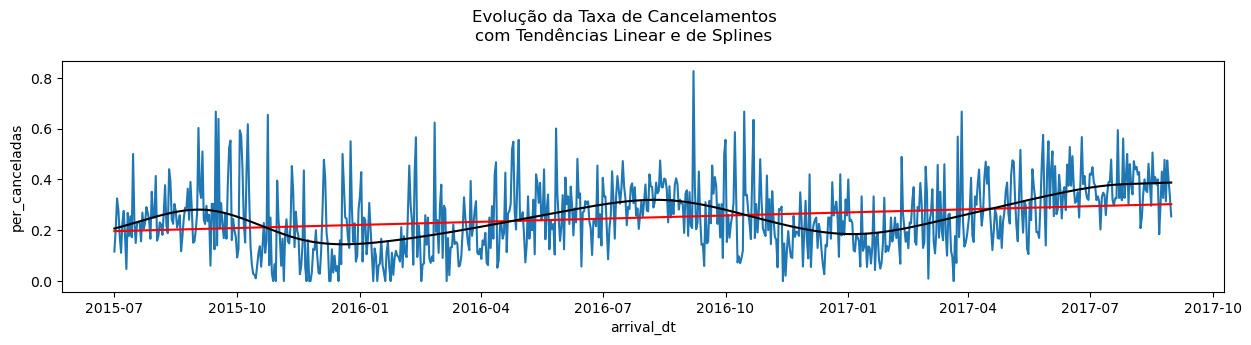

In [61]:
train_data, test_data = split_hotel_ts(tb_resort_ts_b, "2017-08-01")
spline_fit = lm.RidgeCV(cv=5)

spline_fit.fit(train_data[spl_names + ["t_dias"]], train_data["per_canceladas"])
tb_resort_ts_b["pred_spline"] = spline_fit.predict(tb_resort_ts_b[spl_names + ["t_dias"]])

fig, ax = plt.subplots(1, 1, figsize=(15, 3))
sns.lineplot(data=tb_resort_ts_b, x="arrival_dt", y="per_canceladas")
sns.lineplot(data=tb_resort_ts_b, x="arrival_dt", y="pred_trend_linear", color="red")
sns.lineplot(data=tb_resort_ts_b, x="arrival_dt", y="pred_spline", color="black")
fig.suptitle(
    f"Evolução da Taxa de Cancelamentos\ncom Tendências Linear e de Splines",
    y=1.05,
)


In [62]:
test_data["pred_trend_linear"] = trend_fit.predict(test_data[["t_dias"]])
test_data["pred_trend_spline"] = spline_fit.predict(test_data[spl_names + ["t_dias"]])
rmse_lin = np.sqrt(
    mean_squared_error(test_data["per_canceladas"], test_data["pred_trend_linear"])
)
rmse_spl = np.sqrt(
    mean_squared_error(test_data["per_canceladas"], test_data["pred_trend_spline"])
)
print(f"Trend Lin.: {round(rmse_lin, 2)}")
print(f"Trend Spline.: {round(rmse_spl, 2)}")


Trend Lin.: 0.11
Trend Spline.: 0.08


## Componente Sazonal

### Variáveis Sazonais Dummy

In [63]:
tb_resort_ts_b["mes"] = tb_resort_ts_b["arrival_dt"].dt.month.astype(str)
tb_resort_ts_b["dia_semana"] = tb_resort_ts_b["arrival_dt"].dt.weekday.astype(str)


In [64]:
tb_resort_ts_b[["mes", "dia_semana"]]


,mes,dia_semana
0,7,2
1,7,3
2,7,4
3,7,5
4,7,6
...,...,...
788,8,6
789,8,0
790,8,1
791,8,2


In [65]:
tb_resort_ts_b.groupby("dia_semana")["per_canceladas"].mean()

dia_semana
0    0.243317
1    0.218381
2    0.226118
3    0.230869
4    0.287182
5    0.311561
6    0.249483
Name: per_canceladas, dtype: float64

<Axes: xlabel='dia_semana', ylabel='per_canceladas'>

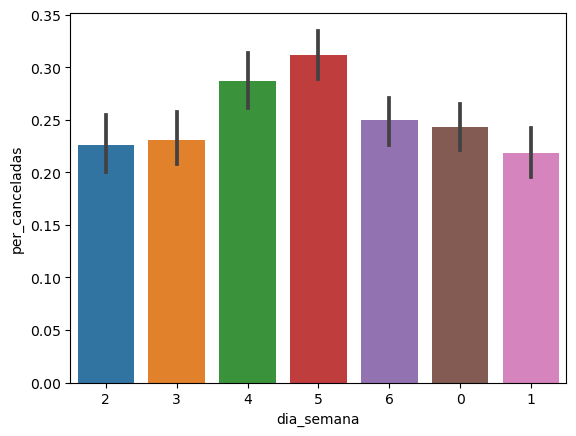

In [66]:
sns.barplot(data = tb_resort_ts_b, x = "dia_semana", y = "per_canceladas")

<Axes: xlabel='mes', ylabel='per_canceladas'>

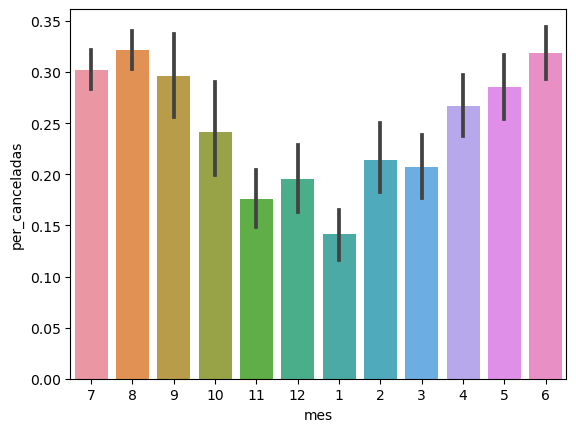

In [67]:
sns.barplot(data = tb_resort_ts_b, x = "mes", y = "per_canceladas")

In [68]:
ohe_fit = OneHotEncoder(drop="first", sparse=False)
ohe_fit.fit(tb_resort_ts_b[["mes", "dia_semana"]])
tb_resort_ts_d = pd.concat(
    [
        tb_resort_ts_b,
        pd.DataFrame(
            ohe_fit.transform(tb_resort_ts_b[["mes", "dia_semana"]]),
            columns=ohe_fit.get_feature_names_out(),
        ),
    ],
    axis=1,
)


/Users/pedroteche/miniconda3/envs/timeseries/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [69]:
tb_resort_ts_d.head()


,arrival_dt,num_reservas,num_canceladas,per_canceladas,t_dias,pred_trend_linear,S0,S1,S2,S3,...,mes_6,mes_7,mes_8,mes_9,dia_semana_1,dia_semana_2,dia_semana_3,dia_semana_4,dia_semana_5,dia_semana_6
0,2015-07-01,43,5,0.116279,0.0,0.196375,0.166667,0.666667,0.166667,0.000000e+00,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,2015-07-02,44,9,0.204545,1.0,0.196509,0.159543,0.666459,0.173997,5.033532e-07,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,2015-07-03,40,13,0.325000,2.0,0.196644,0.152626,0.665843,0.181527,4.026826e-06,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,2015-07-04,50,14,0.280000,3.0,0.196778,0.145911,0.664827,0.189248,1.359054e-05,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,2015-07-05,45,8,0.177778,4.0,0.196912,0.139397,0.663420,0.197151,3.221460e-05,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [71]:
train_data, test_data = split_hotel_ts(tb_resort_ts_d, "2017-08-01")
dummy_names = list(ohe_fit.get_feature_names_out())
var_names = ["t_dias"] + dummy_names
var_names

['t_dias',
 'mes_10',
 'mes_11',
 'mes_12',
 'mes_2',
 'mes_3',
 'mes_4',
 'mes_5',
 'mes_6',
 'mes_7',
 'mes_8',
 'mes_9',
 'dia_semana_1',
 'dia_semana_2',
 'dia_semana_3',
 'dia_semana_4',
 'dia_semana_5',
 'dia_semana_6']

Text(0.5, 1.05, 'Evolução da Taxa de Cancelamentos\ncom Tendências Linear e Índices Sazonais')

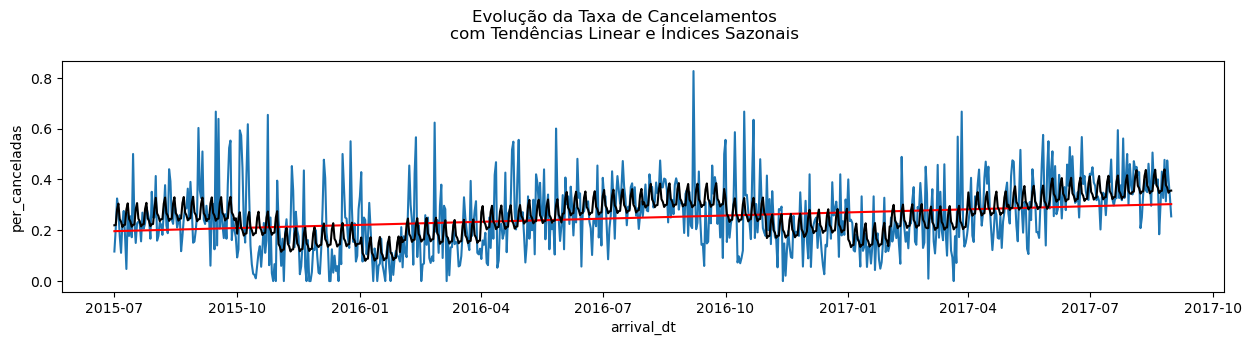

In [72]:
season_trend_fit = lm.LinearRegression()
season_trend_fit.fit(train_data[var_names], train_data["per_canceladas"])

tb_resort_ts_d["pred_trend_season"] = season_trend_fit.predict(
    tb_resort_ts_d[var_names]
)

fig, ax = plt.subplots(1, 1, figsize=(15, 3))
sns.lineplot(data=tb_resort_ts_d, x="arrival_dt", y="per_canceladas")
sns.lineplot(data=tb_resort_ts_d, x="arrival_dt", y="pred_trend_linear", color="red")
sns.lineplot(data=tb_resort_ts_d, x="arrival_dt", y="pred_trend_season", color="black")
fig.suptitle(
    f"Evolução da Taxa de Cancelamentos\ncom Tendências Linear e Índices Sazonais",
    y=1.05,
)


Text(0.5, 1.05, 'Evolução da Taxa de Cancelamentos\ncom Tendências Linear e Índices Sazonais')

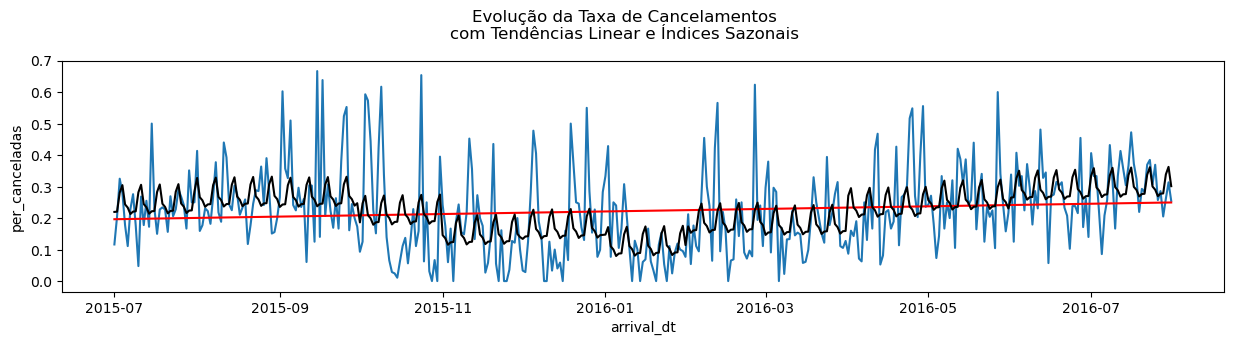

In [73]:
season_trend_fit = lm.LinearRegression()
season_trend_fit.fit(train_data[var_names], train_data["per_canceladas"])

tb_resort_ts_d["pred_trend_season"] = season_trend_fit.predict(
    tb_resort_ts_d[var_names]
)

fig, ax = plt.subplots(1, 1, figsize=(15, 3))
sns.lineplot(data=tb_resort_ts_d[tb_resort_ts_d["arrival_dt"] < "2016-08-01"], x="arrival_dt", y="per_canceladas")
sns.lineplot(data=tb_resort_ts_d[tb_resort_ts_d["arrival_dt"] < "2016-08-01"], x="arrival_dt", y="pred_trend_linear", color="red")
sns.lineplot(data=tb_resort_ts_d[tb_resort_ts_d["arrival_dt"] < "2016-08-01"], x="arrival_dt", y="pred_trend_season", color="black")
fig.suptitle(
    f"Evolução da Taxa de Cancelamentos\ncom Tendências Linear e Índices Sazonais",
    y=1.05,
)


Text(0.5, 1.05, 'Evolução da Taxa de Cancelamentos\ncom Tendências Linear e Índices Sazonais')

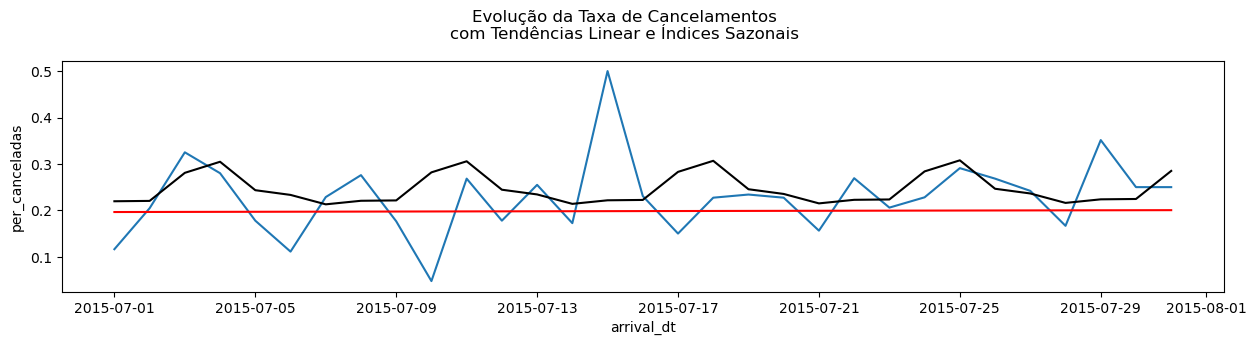

In [74]:
season_trend_fit = lm.LinearRegression()
season_trend_fit.fit(train_data[var_names], train_data["per_canceladas"])

tb_resort_ts_d["pred_trend_season"] = season_trend_fit.predict(
    tb_resort_ts_d[var_names]
)

fig, ax = plt.subplots(1, 1, figsize=(15, 3))
sns.lineplot(data=tb_resort_ts_d[tb_resort_ts_d["arrival_dt"] < "2015-08-01"], x="arrival_dt", y="per_canceladas")
sns.lineplot(data=tb_resort_ts_d[tb_resort_ts_d["arrival_dt"] < "2015-08-01"], x="arrival_dt", y="pred_trend_linear", color="red")
sns.lineplot(data=tb_resort_ts_d[tb_resort_ts_d["arrival_dt"] < "2015-08-01"], x="arrival_dt", y="pred_trend_season", color="black")
fig.suptitle(
    f"Evolução da Taxa de Cancelamentos\ncom Tendências Linear e Índices Sazonais",
    y=1.05,
)


Text(0.5, 1.05, 'Evolução da Taxa de Cancelamentos\ncom Tendências Linear e Índices Sazonais')

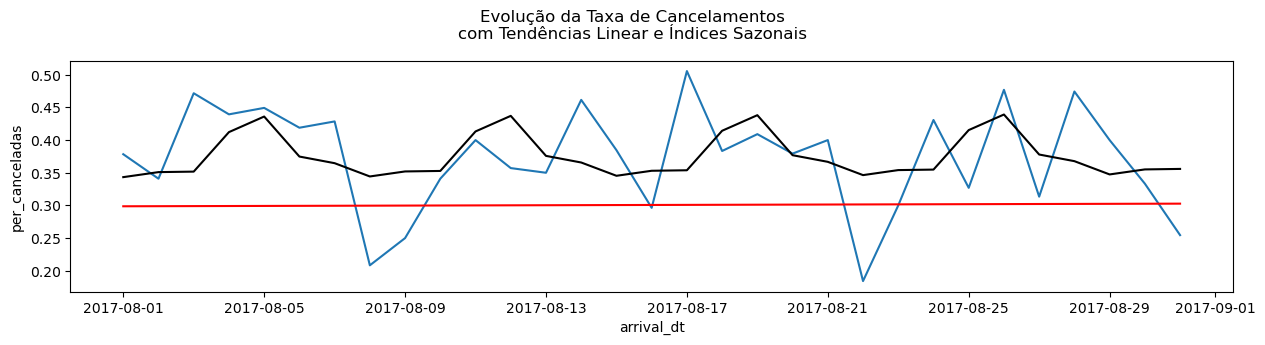

In [75]:
fig, ax = plt.subplots(1, 1, figsize=(15, 3))
sns.lineplot(
    data=tb_resort_ts_d[tb_resort_ts_d["arrival_dt"] >= "2017-08-01"],
    x="arrival_dt",
    y="per_canceladas",
)
sns.lineplot(
    data=tb_resort_ts_d[tb_resort_ts_d["arrival_dt"] >= "2017-08-01"],
    x="arrival_dt",
    y="pred_trend_linear",
    color="red",
)
sns.lineplot(
    data=tb_resort_ts_d[tb_resort_ts_d["arrival_dt"] >= "2017-08-01"],
    x="arrival_dt",
    y="pred_trend_season",
    color="black",
)
fig.suptitle(
    f"Evolução da Taxa de Cancelamentos\ncom Tendências Linear e Índices Sazonais",
    y=1.05,
)


In [76]:
test_data["pred_trend_linear"] = trend_fit.predict(test_data[["t_dias"]])
test_data["pred_trend_season"] = season_trend_fit.predict(test_data[var_names])
rmse_lin = np.sqrt(
    mean_squared_error(test_data["per_canceladas"], test_data["pred_trend_linear"])
)
rmse_cycle = np.sqrt(
    mean_squared_error(test_data["per_canceladas"], test_data["pred_trend_season"])
)
print(f"Trend Lin.: {round(rmse_lin, 2)}")
print(f"Trend + Season: {round(rmse_cycle, 2)}")


Trend Lin.: 0.11
Trend + Season: 0.07


# Criando nosso modelo final

In [77]:
final_list = spl_names + dummy_names + ["t_dias"]
X_train = train_data[final_list]
X_test = test_data[final_list]
y_train = train_data["per_canceladas"]
y_test = test_data["per_canceladas"]
scaler = StandardScaler()
scaler.fit(X_train)

cat_fit = cat.CatBoostRegressor(
    iterations=20000, depth=9, od_type="Iter", od_wait=1500, verbose=False
)
cat_fit.fit(
    scaler.transform(X_train), y_train, eval_set=(scaler.transform(X_test), y_test)
)


Trend Lin.: 0.11
Trend Spline.: 0.08
Trend+Sazonal: 0.07
Trend+Spline+Seazonal: 0.08


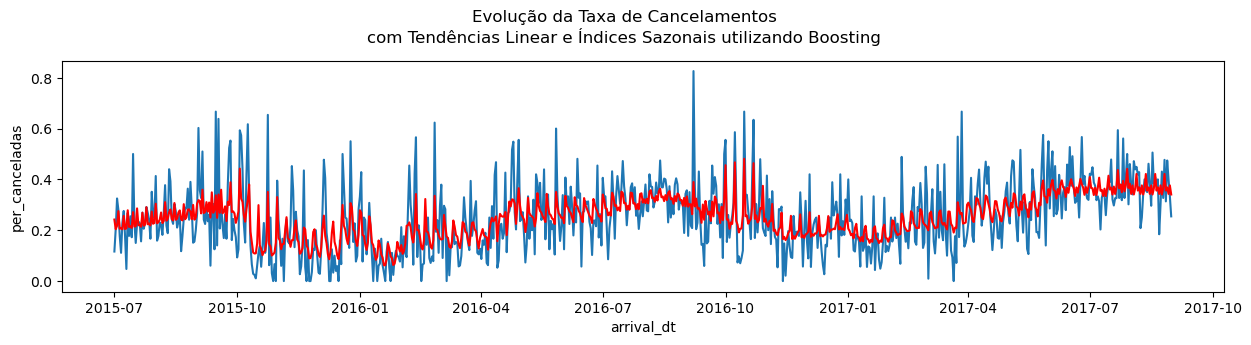

In [78]:
tb_resort_ts_d["pred_boosting"] = cat_fit.predict(
    scaler.transform(tb_resort_ts_d[final_list])
)

fig, ax = plt.subplots(1, 1, figsize=(15, 3))
sns.lineplot(data=tb_resort_ts_d, x="arrival_dt", y="per_canceladas")
sns.lineplot(data=tb_resort_ts_d, x="arrival_dt", y="pred_boosting", color="red")
fig.suptitle(
    f"Evolução da Taxa de Cancelamentos\ncom Tendências Linear e Índices Sazonais utilizando Boosting",
    y=1.05,
)

pred_boosting = cat_fit.predict(scaler.transform(X_test[final_list]))
rmse_cat = np.sqrt(mean_squared_error(y_test, pred_boosting))
print(f"Trend Lin.: {round(rmse_lin, 2)}")
print(f"Trend Spline.: {round(rmse_spl, 2)}")
print(f"Trend+Sazonal: {round(rmse_cycle, 2)}")
print(f"Trend+Spline+Seazonal: {round(rmse_cat, 2)}")


Text(0.5, 1.05, 'Evolução da Taxa de Cancelamentos\ncom Tendências Linear e Índices Sazonais utilizando Boosting')

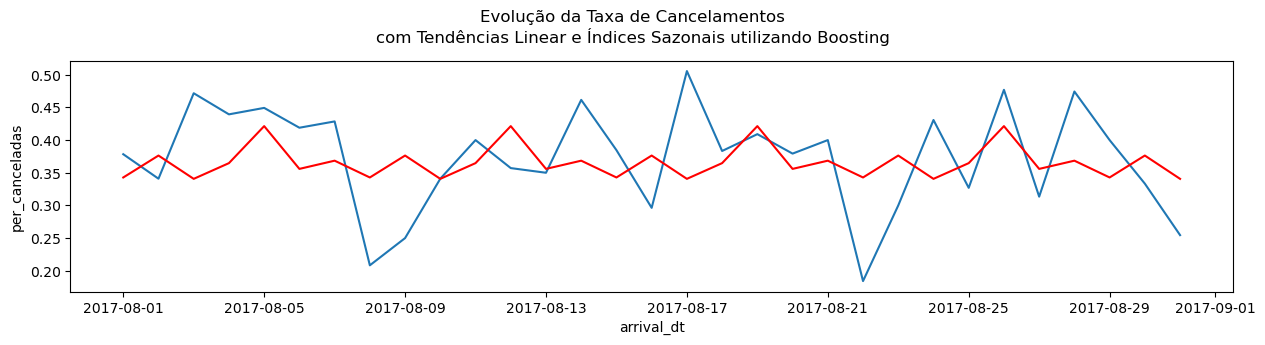

In [79]:
fig, ax = plt.subplots(1, 1, figsize=(15, 3))
sns.lineplot(
    data=tb_resort_ts_d[tb_resort_ts_d["arrival_dt"] >= "2017-08-01"],
    x="arrival_dt",
    y="per_canceladas",
)
sns.lineplot(
    data=tb_resort_ts_d[tb_resort_ts_d["arrival_dt"] >= "2017-08-01"],
    x="arrival_dt",
    y="pred_boosting",
    color="red",
)
fig.suptitle(
    f"Evolução da Taxa de Cancelamentos\ncom Tendências Linear e Índices Sazonais utilizando Boosting",
    y=1.05,
)


In [81]:
tb_resort_ts_d["year"] = tb_resort_ts_d["arrival_dt"].dt.year
tb_resort_ts_d["month"] = tb_resort_ts_d["arrival_dt"].dt.month

In [84]:
tb_mensal = (
    tb_resort_ts_d
    .groupby(["year", "month"])
    .agg(pred_cancelada = ("pred_boosting", "mean"), real_cancelada = ("per_canceladas", "mean"))
    .reset_index()
)

In [85]:
tb_mensal.head()

,year,month,pred_cancelada,real_cancelada
0,2015,7,0.231640,0.227889
1,2015,8,0.259954,0.255512
2,2015,9,0.293631,0.304318
3,2015,10,0.206436,0.203602
4,2015,11,0.158366,0.155055


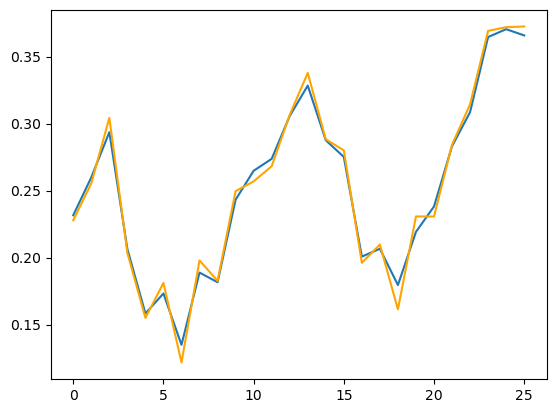

In [87]:
plt.plot(tb_mensal["pred_cancelada"])
plt.plot(tb_mensal["real_cancelada"], color = "orange")

# Processos Auto-regressivos

**Introdução aos Modelos Auto-regressivos para Estudantes Não-STEM**

Os modelos auto-regressivos são um tipo de modelo estatístico especialmente útil para analisar e prever padrões em dados sequenciais. Esse tipo de dado é caracterizado por sua natureza temporal ou sequencial, onde as observações são coletadas ao longo do tempo e ordenadas em uma sequência específica. Exemplos de dados sequenciais incluem:

- Preços de ações
- Medidas climáticas
- Sequências de linguagem
- Indicadores econômicos

A ideia principal por trás dos modelos auto-regressivos é aproveitar as informações das observações anteriores para fazer previsões sobre valores futuros. Em outras palavras, esses modelos levam em consideração a relação entre observações atuais e passadas para estimar o que pode acontecer a seguir. Isso os torna adequados para tarefas como:

- Previsão de séries temporais
- Previsão de valores futuros com base em dados históricos

Os modelos auto-regressivos se baseiam na suposição de que os valores futuros de uma sequência dependem linearmente de seus valores passados. Isso significa que o modelo estima o valor atual combinando uma soma ponderada de observações anteriores, em que os pesos representam a importância ou contribuição de cada observação passada. O número de observações passadas usadas para a previsão é frequentemente chamado de "ordem" do modelo.

Para ilustrar isso, vamos considerar um exemplo simples. Suponha que tenhamos um conjunto de dados de séries temporais com medidas diárias de temperatura. Podemos usar um modelo auto-regressivo para prever a temperatura de amanhã com base nas temperaturas dos dias anteriores. Ao analisar os padrões e relacionamentos nos dados históricos, o modelo pode estimar a temperatura para o próximo dia.

Os modelos auto-regressivos existem em várias formas, sendo o mais comum o **modelo Auto-Regressivo (AR)**. Outras variações incluem o **modelo de Médias Móveis (MA)** e o **modelo Auto-Regressivo de Médias Móveis (ARMA)**. Além disso, modelos mais avançados, como o **modelo Auto-Regressivo Integrado de Médias Móveis (ARIMA)** e suas extensões, incorporam técnicas de diferenciação e integração para lidar com dados não estacionários.

Embora os modelos auto-regressivos tenham suas raízes na estatística, eles encontraram aplicações em diversos campos além da matemática. Por exemplo:

- Economistas utilizam esses modelos para prever tendências no mercado financeiro
- Engenheiros os utilizam para processamento de sinais
- Pesquisadores de processamento de linguagem natural os empregam para geração de linguagem e tradução automática


## Auto-correlação e Autocorrelação Parcial

**Auto-correlação:**
A *auto-correlação* é uma medida estatística que descreve o grau de dependência entre observações em uma série temporal. Ela quantifica a relação entre uma observação atual e as observações anteriores em diferentes defasagens. Em outras palavras, a auto-correlação indica se há uma relação linear entre os valores de uma série temporal em diferentes momentos no tempo. Uma autocorrelação positiva indica uma relação positiva entre os valores, enquanto uma autocorrelação negativa indica uma relação negativa. A auto-correlação é comumente usada para identificar:

- Padrões sazonais
- Tendências
- Ciclos em séries temporais.

**Auto-correlação parcial:**
A *auto-correlação parcial* é uma medida estatística que mede a relação entre duas observações em uma série temporal, controlando o efeito das observações intermediárias. Em outras palavras, a auto-correlação parcial indica a correlação entre uma observação e outra observação anterior, removendo o efeito das observações intermediárias. Ela ajuda a identificar a contribuição específica de cada observação passada para a relação com a observação atual. A auto-correlação parcial é útil na modelagem de séries temporais, especialmente na identificação da ordem adequada de um modelo auto-regressivo (AR) ao analisar dados sequenciais.

Ambas a auto-correlação e a auto-correlação parcial são ferramentas estatísticas essenciais na análise de séries temporais e na construção de modelos auto-regressivos. Elas fornecem informações sobre as relações de dependência entre as observações, ajudando a compreender a estrutura subjacente dos dados e a escolher a abordagem correta de modelagem para fazer previsões precisas.

Text(0.5, 1.05, 'Evolução do Número de Reservas')

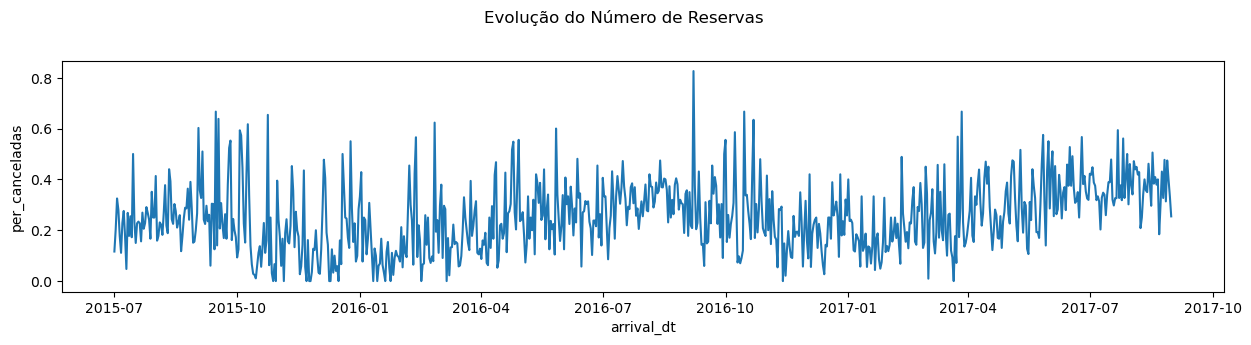

In [88]:
fig, ax = plt.subplots(1, 1, figsize=(15, 3))
sns.lineplot(data=tb_resort_ts_d, x="arrival_dt", y="per_canceladas")
fig.suptitle(
    f"Evolução do Número de Reservas",
    y=1.05,
)


O método `.shift()` retorna uma série *atrasada* (ou *adiantada*) em relação a série original:

In [89]:
tb_resort_ts_d["per_canceladas_lag"] = tb_resort_ts_d["per_canceladas"].shift(1)
tb_resort_ts_d[["per_canceladas", "per_canceladas_lag"]].head()


,per_canceladas,per_canceladas_lag
0,0.116279,NaN
1,0.204545,0.116279
2,0.325000,0.204545
3,0.280000,0.325000
4,0.177778,0.280000


Com esta nova coluna (`per_canceladas_lag`) podemos **visualizar** a auto-correlação (no horizonte de 1 dia) da série `per_canceladas`: a auto-correlação é a correlação de uma série temporal com seu **passado**!

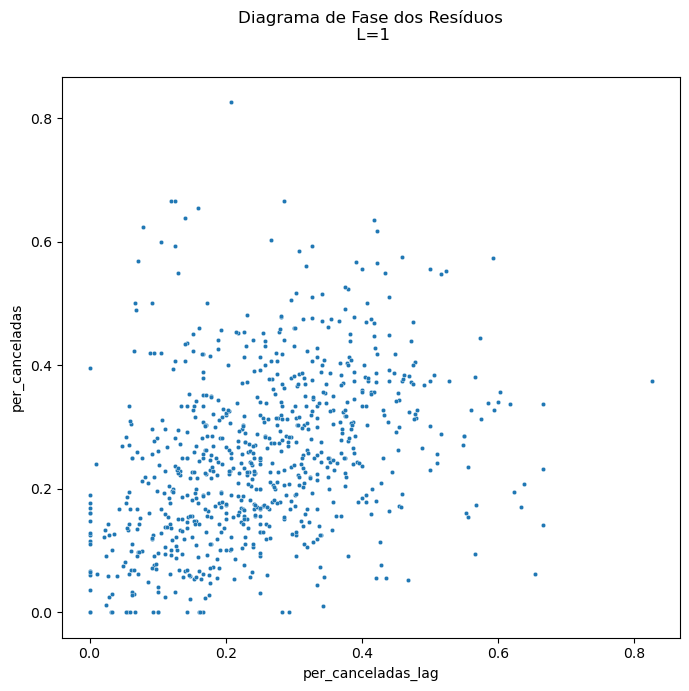

In [92]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
sns.scatterplot(
    data=tb_resort_ts_d,
    x="per_canceladas_lag",
    y="per_canceladas",
    s=10
)
ax.set_title(f"Diagrama de Fase dos Resíduos\n L=1", y=1.05)
fig.tight_layout()


O diagrama de fase nos permite visualizar de forma simples a correlação para alguns (no caso acima um) período de lag - mas podemos ter autocorrelação em diversos atrasos (especialmente se nossa série tem sazonalidade).

Temos duas ferramentas disponíveis para entender a estrutura de auto-correlação de uma série temporal: a ACF e a PACF.

In [93]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

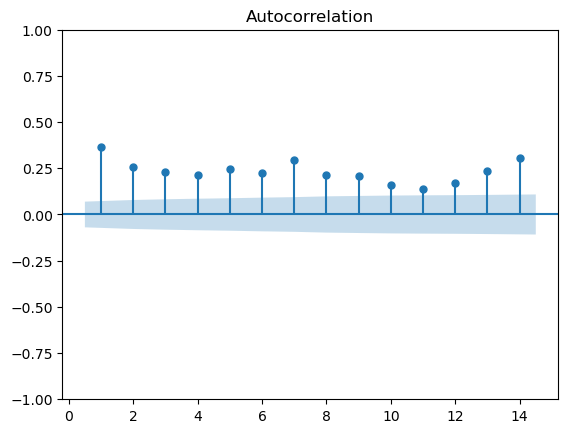

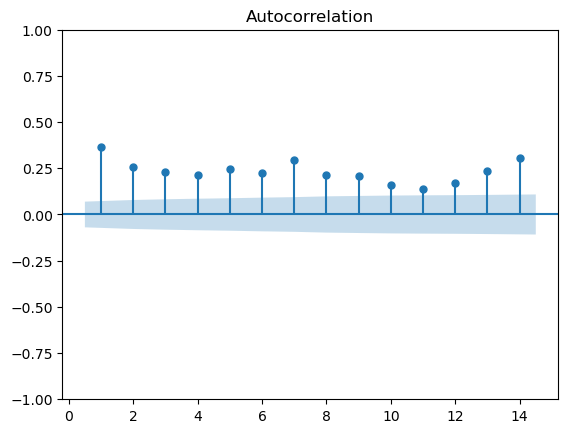

In [94]:
plot_acf(tb_resort_ts_d["per_canceladas"], lags=range(1, 15))


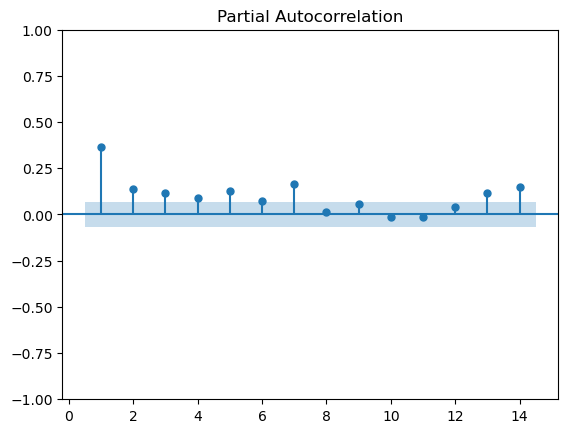

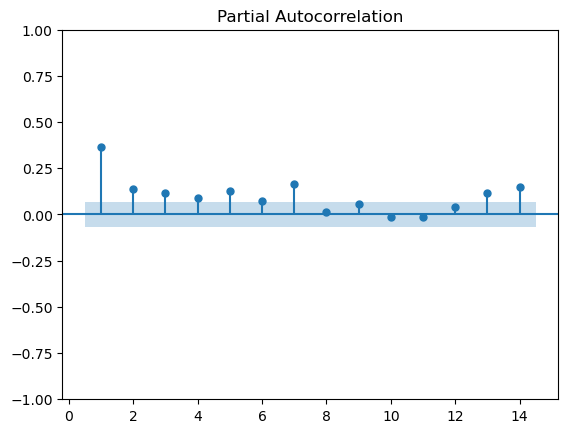

In [95]:
plot_pacf(tb_resort_ts_d["per_canceladas"], lags=range(1, 15), method="ywm")


A questão da inter-dependencia das observações é crítica em séries temporais - nossos modelos anteriores assumiam que as observações eram independentes entre si, o que não é o caso em séries temporais. Vamos ver se o erro do nosso modelo acima tinha autocorrelação:

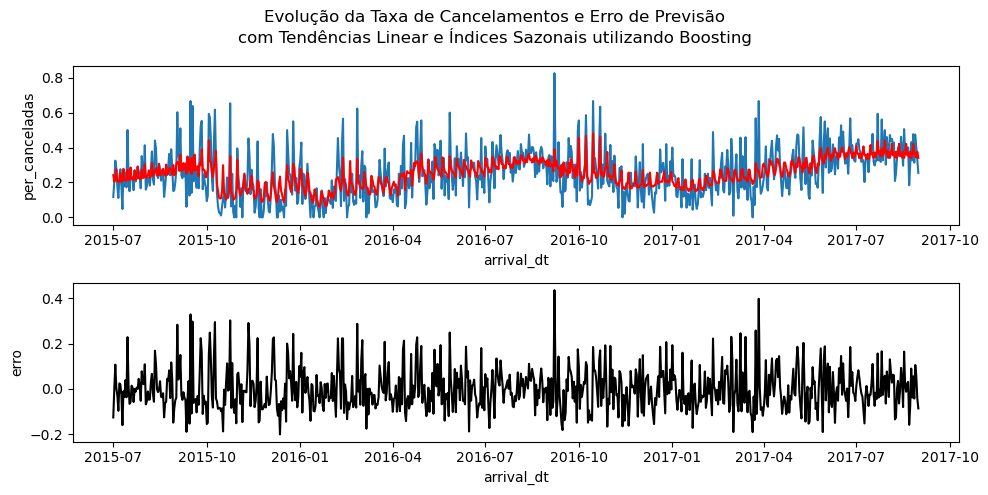

In [96]:
tb_resort_ts_d["erro"] = (
    tb_resort_ts_d["per_canceladas"] - tb_resort_ts_d["pred_boosting"]
)

fig, ax = plt.subplots(2, 1, figsize=(10, 5))
sns.lineplot(data=tb_resort_ts_d, x="arrival_dt", y="per_canceladas", ax=ax[0])
sns.lineplot(
    data=tb_resort_ts_d, x="arrival_dt", y="pred_boosting", color="red", ax=ax[0]
)
sns.lineplot(data=tb_resort_ts_d, x="arrival_dt", y="erro", color="black", ax=ax[1])

fig.suptitle(
    f"Evolução da Taxa de Cancelamentos e Erro de Previsão\ncom Tendências Linear e Índices Sazonais utilizando Boosting"
)
fig.tight_layout()


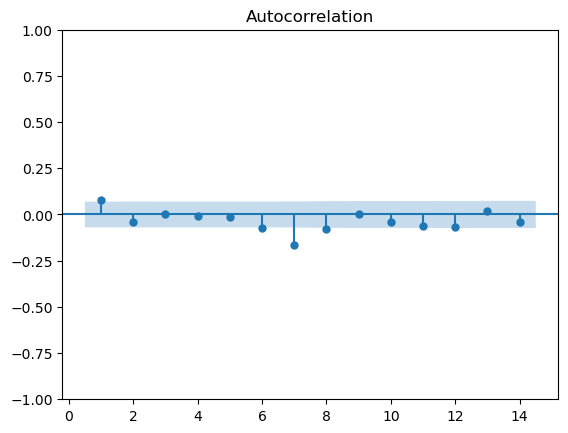

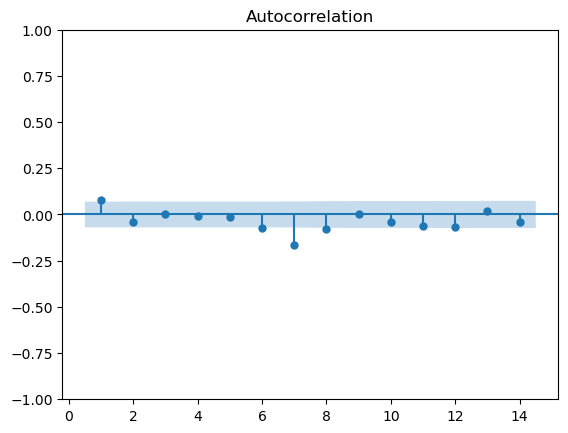

In [97]:
plot_acf(tb_resort_ts_d["erro"], lags=range(1, 15))


Qualquer autocorrelação que exista no **erro** do modelo é informação *jogada fora*: poderíamos incorporar essa informação no modelo e melhorar nossa previsão. Mas como podemos fazer isso?

A forma *naive* seria utilizando o método `.shift()` para gerar uma série de lags da série temporal e incorporar essas variáveis no modelo. No entanto, isso tornará muito dificíl fazer previsões: para prever um horizonte maior que 1, precisaríamos da projeção no dia anterior!

Vamos utilizar a biblioteca `scalecast` para criar um workflow de trabalho com séries temporais:

In [98]:
from scalecast.Forecaster import Forecaster

O objeto central da biblioteca `scalecast` é o Forecast - ele age como uma combinação de `DataFrame` com `pipeline`:

In [ ]:
tb_resort_ts_d["arrival_dt"]

In [99]:
f = Forecaster(
    y=tb_resort_ts_d["per_canceladas"],  # Nossa séries temporal
    current_dates=tb_resort_ts_d["arrival_dt"],  # Datas associadas à nossa série temporal
    future_dates=7,  # Comprimento do horizonte de forecast
    test_length=90,  # Comprimento do conjunto de teste
    metrics=["rmse"],  # Métrica de avaliação do nosso modelo
)


Podemos utilizar o método `.plot()` para visualizar nossa série temporal em nosso `Forecaster`:

<Axes: xlabel='Date', ylabel='Values'>

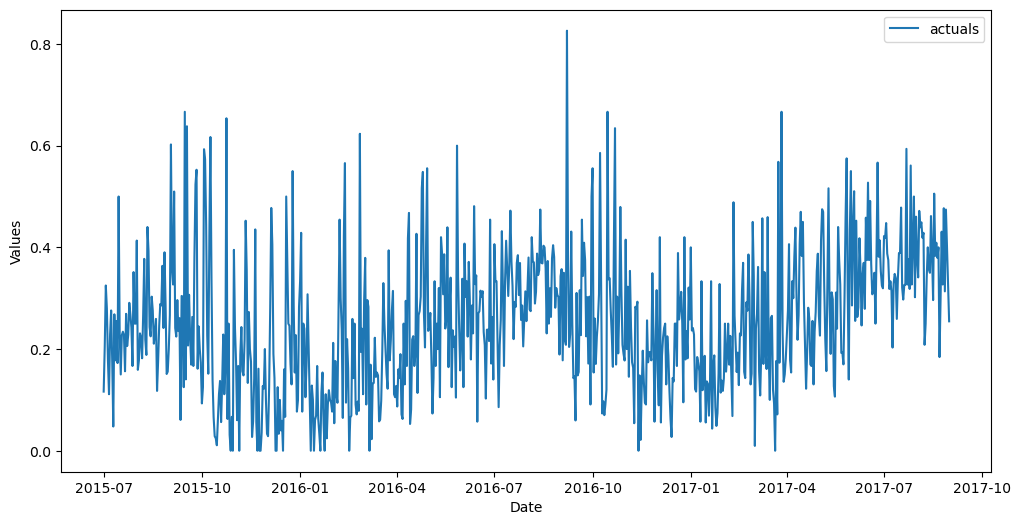

In [100]:
f.plot()

Agora, vamos utilizar métodos de nosso Forecaster para especificar nosso modelo:

In [101]:
f.add_time_trend() # Tendencia linear
f.add_seasonal_regressors("month", raw = False, dummy = True, drop_first = True) # Sazonalidade mensal
f.add_seasonal_regressors('dayofweek', raw=False, dummy=True, drop_first = True) # Sazonalidade do dia da semana

Para adicionar nossos termos autoregressivos utilizamos o método `.add_ar_terms()`:

In [102]:
f.add_ar_terms(7) # Termos autorregressivos (7)

In [103]:
f.eval_cis(
    mode = True, # tell the object to evaluate intervals
    cilevel = .95, # 95% confidence level
)

In [104]:
f.set_estimator('mlr')
f.manual_forecast(dynamic_testing=90)

In [105]:
f.set_estimator('catboost')
f.manual_forecast(iterations = 1000, max_depth = 10, dynamic_testing=90)

Learning rate set to 0.038664
0:	learn: 0.1334091	total: 10.6ms	remaining: 10.6s
1:	learn: 0.1323597	total: 19.8ms	remaining: 9.89s
2:	learn: 0.1312780	total: 30.9ms	remaining: 10.3s
3:	learn: 0.1300051	total: 38.4ms	remaining: 9.57s
4:	learn: 0.1290215	total: 49.4ms	remaining: 9.82s
5:	learn: 0.1279576	total: 55.3ms	remaining: 9.16s
6:	learn: 0.1270386	total: 62.7ms	remaining: 8.89s
7:	learn: 0.1259437	total: 69.3ms	remaining: 8.6s
8:	learn: 0.1249218	total: 77.4ms	remaining: 8.52s
9:	learn: 0.1240594	total: 85.6ms	remaining: 8.48s
10:	learn: 0.1231127	total: 93.6ms	remaining: 8.41s
11:	learn: 0.1223859	total: 110ms	remaining: 9.02s
12:	learn: 0.1214999	total: 123ms	remaining: 9.33s
13:	learn: 0.1207265	total: 129ms	remaining: 9.12s
14:	learn: 0.1197678	total: 135ms	remaining: 8.89s
15:	learn: 0.1189671	total: 141ms	remaining: 8.7s
16:	learn: 0.1183268	total: 147ms	remaining: 8.5s
17:	learn: 0.1174662	total: 152ms	remaining: 8.31s
18:	learn: 0.1166784	total: 159ms	remaining: 8.21s
19:

180:	learn: 0.0581506	total: 1.21s	remaining: 5.46s
181:	learn: 0.0578404	total: 1.22s	remaining: 5.46s
182:	learn: 0.0576573	total: 1.23s	remaining: 5.47s
183:	learn: 0.0573409	total: 1.24s	remaining: 5.49s
184:	learn: 0.0571349	total: 1.24s	remaining: 5.48s
185:	learn: 0.0568786	total: 1.25s	remaining: 5.46s
186:	learn: 0.0566462	total: 1.25s	remaining: 5.46s
187:	learn: 0.0564765	total: 1.26s	remaining: 5.44s
188:	learn: 0.0563194	total: 1.27s	remaining: 5.43s
189:	learn: 0.0561357	total: 1.27s	remaining: 5.43s
190:	learn: 0.0560469	total: 1.28s	remaining: 5.42s
191:	learn: 0.0558882	total: 1.29s	remaining: 5.41s
192:	learn: 0.0556874	total: 1.29s	remaining: 5.41s
193:	learn: 0.0554908	total: 1.3s	remaining: 5.39s
194:	learn: 0.0552778	total: 1.3s	remaining: 5.38s
195:	learn: 0.0550592	total: 1.31s	remaining: 5.38s
196:	learn: 0.0548781	total: 1.32s	remaining: 5.37s
197:	learn: 0.0546050	total: 1.32s	remaining: 5.36s
198:	learn: 0.0544830	total: 1.33s	remaining: 5.35s
199:	learn: 0.

346:	learn: 0.0342812	total: 2.42s	remaining: 4.55s
347:	learn: 0.0341649	total: 2.43s	remaining: 4.55s
348:	learn: 0.0340523	total: 2.44s	remaining: 4.55s
349:	learn: 0.0339043	total: 2.44s	remaining: 4.54s
350:	learn: 0.0337955	total: 2.45s	remaining: 4.53s
351:	learn: 0.0337321	total: 2.46s	remaining: 4.53s
352:	learn: 0.0336075	total: 2.47s	remaining: 4.52s
353:	learn: 0.0335676	total: 2.47s	remaining: 4.51s
354:	learn: 0.0334495	total: 2.48s	remaining: 4.5s
355:	learn: 0.0332623	total: 2.48s	remaining: 4.49s
356:	learn: 0.0331940	total: 2.49s	remaining: 4.48s
357:	learn: 0.0330102	total: 2.49s	remaining: 4.47s
358:	learn: 0.0329149	total: 2.5s	remaining: 4.46s
359:	learn: 0.0327558	total: 2.5s	remaining: 4.45s
360:	learn: 0.0326632	total: 2.51s	remaining: 4.44s
361:	learn: 0.0325968	total: 2.51s	remaining: 4.43s
362:	learn: 0.0324580	total: 2.52s	remaining: 4.42s
363:	learn: 0.0324507	total: 2.53s	remaining: 4.42s
364:	learn: 0.0323633	total: 2.54s	remaining: 4.42s
365:	learn: 0.0

522:	learn: 0.0195351	total: 3.63s	remaining: 3.31s
523:	learn: 0.0194483	total: 3.64s	remaining: 3.31s
524:	learn: 0.0193881	total: 3.65s	remaining: 3.3s
525:	learn: 0.0193256	total: 3.66s	remaining: 3.29s
526:	learn: 0.0192613	total: 3.67s	remaining: 3.29s
527:	learn: 0.0191905	total: 3.67s	remaining: 3.28s
528:	learn: 0.0191227	total: 3.68s	remaining: 3.28s
529:	learn: 0.0190934	total: 3.69s	remaining: 3.27s
530:	learn: 0.0190206	total: 3.69s	remaining: 3.26s
531:	learn: 0.0189692	total: 3.7s	remaining: 3.26s
532:	learn: 0.0188815	total: 3.71s	remaining: 3.25s
533:	learn: 0.0188294	total: 3.72s	remaining: 3.24s
534:	learn: 0.0187271	total: 3.72s	remaining: 3.24s
535:	learn: 0.0186717	total: 3.73s	remaining: 3.23s
536:	learn: 0.0186165	total: 3.74s	remaining: 3.22s
537:	learn: 0.0185728	total: 3.74s	remaining: 3.21s
538:	learn: 0.0185224	total: 3.75s	remaining: 3.21s
539:	learn: 0.0184298	total: 3.75s	remaining: 3.2s
540:	learn: 0.0183595	total: 3.76s	remaining: 3.19s
541:	learn: 0.0

693:	learn: 0.0114089	total: 4.85s	remaining: 2.14s
694:	learn: 0.0113890	total: 4.86s	remaining: 2.13s
695:	learn: 0.0113440	total: 4.87s	remaining: 2.13s
696:	learn: 0.0113199	total: 4.88s	remaining: 2.12s
697:	learn: 0.0112928	total: 4.88s	remaining: 2.11s
698:	learn: 0.0112477	total: 4.89s	remaining: 2.11s
699:	learn: 0.0112313	total: 4.9s	remaining: 2.1s
700:	learn: 0.0111886	total: 4.9s	remaining: 2.09s
701:	learn: 0.0111380	total: 4.91s	remaining: 2.08s
702:	learn: 0.0110844	total: 4.91s	remaining: 2.08s
703:	learn: 0.0110567	total: 4.92s	remaining: 2.07s
704:	learn: 0.0110187	total: 4.92s	remaining: 2.06s
705:	learn: 0.0109707	total: 4.93s	remaining: 2.05s
706:	learn: 0.0109563	total: 4.94s	remaining: 2.04s
707:	learn: 0.0109140	total: 4.94s	remaining: 2.04s
708:	learn: 0.0108696	total: 4.95s	remaining: 2.03s
709:	learn: 0.0108396	total: 4.96s	remaining: 2.02s
710:	learn: 0.0107965	total: 4.96s	remaining: 2.02s
711:	learn: 0.0107794	total: 4.97s	remaining: 2.01s
712:	learn: 0.0

875:	learn: 0.0064832	total: 6.06s	remaining: 858ms
876:	learn: 0.0064705	total: 6.06s	remaining: 851ms
877:	learn: 0.0064551	total: 6.07s	remaining: 844ms
878:	learn: 0.0064399	total: 6.08s	remaining: 837ms
879:	learn: 0.0064206	total: 6.09s	remaining: 830ms
880:	learn: 0.0063996	total: 6.09s	remaining: 823ms
881:	learn: 0.0063761	total: 6.1s	remaining: 816ms
882:	learn: 0.0063644	total: 6.11s	remaining: 809ms
883:	learn: 0.0063339	total: 6.11s	remaining: 802ms
884:	learn: 0.0063149	total: 6.12s	remaining: 795ms
885:	learn: 0.0063022	total: 6.13s	remaining: 788ms
886:	learn: 0.0062673	total: 6.13s	remaining: 781ms
887:	learn: 0.0062612	total: 6.13s	remaining: 774ms
888:	learn: 0.0062308	total: 6.14s	remaining: 767ms
889:	learn: 0.0062075	total: 6.15s	remaining: 760ms
890:	learn: 0.0061912	total: 6.15s	remaining: 753ms
891:	learn: 0.0061700	total: 6.16s	remaining: 746ms
892:	learn: 0.0061415	total: 6.16s	remaining: 739ms
893:	learn: 0.0061234	total: 6.17s	remaining: 732ms
894:	learn: 0

34:	learn: 0.1045094	total: 310ms	remaining: 8.56s
35:	learn: 0.1039299	total: 319ms	remaining: 8.55s
36:	learn: 0.1034310	total: 329ms	remaining: 8.57s
37:	learn: 0.1029462	total: 341ms	remaining: 8.64s
38:	learn: 0.1024047	total: 350ms	remaining: 8.62s
39:	learn: 0.1018314	total: 356ms	remaining: 8.54s
40:	learn: 0.1013925	total: 363ms	remaining: 8.49s
41:	learn: 0.1008922	total: 371ms	remaining: 8.45s
42:	learn: 0.1003309	total: 380ms	remaining: 8.47s
43:	learn: 0.0997510	total: 390ms	remaining: 8.48s
44:	learn: 0.0992966	total: 397ms	remaining: 8.43s
45:	learn: 0.0986769	total: 404ms	remaining: 8.38s
46:	learn: 0.0981475	total: 415ms	remaining: 8.41s
47:	learn: 0.0977405	total: 423ms	remaining: 8.4s
48:	learn: 0.0972197	total: 437ms	remaining: 8.48s
49:	learn: 0.0967935	total: 449ms	remaining: 8.54s
50:	learn: 0.0963258	total: 457ms	remaining: 8.5s
51:	learn: 0.0959049	total: 465ms	remaining: 8.47s
52:	learn: 0.0955768	total: 475ms	remaining: 8.48s
53:	learn: 0.0952210	total: 482ms

211:	learn: 0.0524346	total: 1.72s	remaining: 6.39s
212:	learn: 0.0522411	total: 1.73s	remaining: 6.39s
213:	learn: 0.0520572	total: 1.74s	remaining: 6.39s
214:	learn: 0.0518852	total: 1.75s	remaining: 6.38s
215:	learn: 0.0517504	total: 1.76s	remaining: 6.37s
216:	learn: 0.0515013	total: 1.76s	remaining: 6.36s
217:	learn: 0.0513484	total: 1.77s	remaining: 6.35s
218:	learn: 0.0511982	total: 1.78s	remaining: 6.34s
219:	learn: 0.0510146	total: 1.78s	remaining: 6.32s
220:	learn: 0.0508684	total: 1.79s	remaining: 6.31s
221:	learn: 0.0507187	total: 1.8s	remaining: 6.3s
222:	learn: 0.0505080	total: 1.8s	remaining: 6.28s
223:	learn: 0.0503312	total: 1.81s	remaining: 6.26s
224:	learn: 0.0502043	total: 1.81s	remaining: 6.25s
225:	learn: 0.0499692	total: 1.82s	remaining: 6.23s
226:	learn: 0.0497337	total: 1.83s	remaining: 6.22s
227:	learn: 0.0496192	total: 1.83s	remaining: 6.2s
228:	learn: 0.0494264	total: 1.84s	remaining: 6.18s
229:	learn: 0.0492823	total: 1.84s	remaining: 6.17s
230:	learn: 0.04

390:	learn: 0.0288314	total: 2.92s	remaining: 4.55s
391:	learn: 0.0286922	total: 2.93s	remaining: 4.54s
392:	learn: 0.0285296	total: 2.93s	remaining: 4.53s
393:	learn: 0.0284188	total: 2.94s	remaining: 4.52s
394:	learn: 0.0282734	total: 2.95s	remaining: 4.51s
395:	learn: 0.0281686	total: 2.95s	remaining: 4.5s
396:	learn: 0.0280919	total: 2.96s	remaining: 4.49s
397:	learn: 0.0279921	total: 2.96s	remaining: 4.49s
398:	learn: 0.0279395	total: 2.97s	remaining: 4.47s
399:	learn: 0.0278393	total: 2.98s	remaining: 4.46s
400:	learn: 0.0277037	total: 2.98s	remaining: 4.45s
401:	learn: 0.0276841	total: 2.99s	remaining: 4.44s
402:	learn: 0.0275813	total: 2.99s	remaining: 4.43s
403:	learn: 0.0274747	total: 3s	remaining: 4.42s
404:	learn: 0.0273906	total: 3.01s	remaining: 4.42s
405:	learn: 0.0272965	total: 3.01s	remaining: 4.41s
406:	learn: 0.0272225	total: 3.02s	remaining: 4.39s
407:	learn: 0.0271102	total: 3.02s	remaining: 4.38s
408:	learn: 0.0270348	total: 3.03s	remaining: 4.37s
409:	learn: 0.02

559:	learn: 0.0172165	total: 4.14s	remaining: 3.25s
560:	learn: 0.0171855	total: 4.14s	remaining: 3.24s
561:	learn: 0.0171393	total: 4.15s	remaining: 3.24s
562:	learn: 0.0170680	total: 4.16s	remaining: 3.23s
563:	learn: 0.0170200	total: 4.17s	remaining: 3.22s
564:	learn: 0.0169561	total: 4.17s	remaining: 3.21s
565:	learn: 0.0168809	total: 4.18s	remaining: 3.21s
566:	learn: 0.0168074	total: 4.2s	remaining: 3.21s
567:	learn: 0.0167371	total: 4.21s	remaining: 3.2s
568:	learn: 0.0166998	total: 4.22s	remaining: 3.19s
569:	learn: 0.0166415	total: 4.23s	remaining: 3.19s
570:	learn: 0.0165920	total: 4.24s	remaining: 3.19s
571:	learn: 0.0165544	total: 4.25s	remaining: 3.18s
572:	learn: 0.0165288	total: 4.26s	remaining: 3.17s
573:	learn: 0.0164962	total: 4.27s	remaining: 3.17s
574:	learn: 0.0164152	total: 4.27s	remaining: 3.16s
575:	learn: 0.0163511	total: 4.28s	remaining: 3.15s
576:	learn: 0.0162834	total: 4.29s	remaining: 3.14s
577:	learn: 0.0162494	total: 4.29s	remaining: 3.13s
578:	learn: 0.

745:	learn: 0.0103549	total: 5.35s	remaining: 1.82s
746:	learn: 0.0103204	total: 5.36s	remaining: 1.81s
747:	learn: 0.0103062	total: 5.37s	remaining: 1.81s
748:	learn: 0.0102889	total: 5.38s	remaining: 1.8s
749:	learn: 0.0102631	total: 5.38s	remaining: 1.79s
750:	learn: 0.0102405	total: 5.39s	remaining: 1.79s
751:	learn: 0.0102177	total: 5.4s	remaining: 1.78s
752:	learn: 0.0101826	total: 5.41s	remaining: 1.77s
753:	learn: 0.0101673	total: 5.41s	remaining: 1.77s
754:	learn: 0.0101511	total: 5.42s	remaining: 1.76s
755:	learn: 0.0101162	total: 5.43s	remaining: 1.75s
756:	learn: 0.0100921	total: 5.43s	remaining: 1.74s
757:	learn: 0.0100611	total: 5.44s	remaining: 1.74s
758:	learn: 0.0100460	total: 5.45s	remaining: 1.73s
759:	learn: 0.0100139	total: 5.45s	remaining: 1.72s
760:	learn: 0.0099959	total: 5.46s	remaining: 1.71s
761:	learn: 0.0099524	total: 5.46s	remaining: 1.71s
762:	learn: 0.0099248	total: 5.47s	remaining: 1.7s
763:	learn: 0.0099029	total: 5.47s	remaining: 1.69s
764:	learn: 0.0

927:	learn: 0.0063587	total: 6.56s	remaining: 509ms
928:	learn: 0.0063417	total: 6.57s	remaining: 502ms
929:	learn: 0.0063327	total: 6.58s	remaining: 495ms
930:	learn: 0.0063159	total: 6.59s	remaining: 488ms
931:	learn: 0.0062881	total: 6.59s	remaining: 481ms
932:	learn: 0.0062793	total: 6.6s	remaining: 474ms
933:	learn: 0.0062499	total: 6.61s	remaining: 467ms
934:	learn: 0.0062292	total: 6.61s	remaining: 460ms
935:	learn: 0.0062176	total: 6.62s	remaining: 453ms
936:	learn: 0.0062036	total: 6.63s	remaining: 446ms
937:	learn: 0.0061823	total: 6.63s	remaining: 438ms
938:	learn: 0.0061571	total: 6.64s	remaining: 431ms
939:	learn: 0.0061415	total: 6.64s	remaining: 424ms
940:	learn: 0.0061259	total: 6.65s	remaining: 417ms
941:	learn: 0.0061007	total: 6.66s	remaining: 410ms
942:	learn: 0.0060933	total: 6.66s	remaining: 403ms
943:	learn: 0.0060775	total: 6.67s	remaining: 395ms
944:	learn: 0.0060593	total: 6.67s	remaining: 388ms
945:	learn: 0.0060477	total: 6.68s	remaining: 381ms
946:	learn: 0

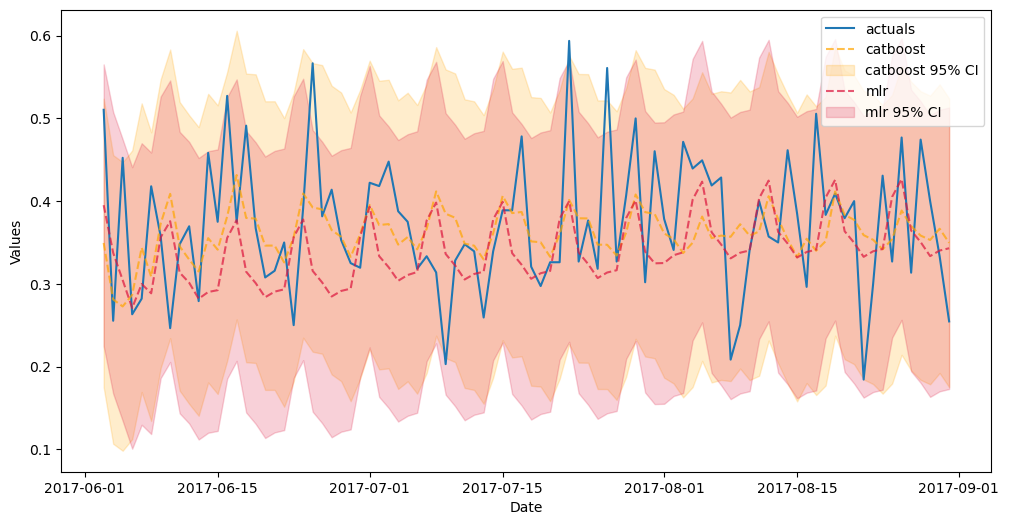

In [110]:
f.plot_test_set(ci=True,models=['mlr','catboost'],order_by='TestSetRMSE', include_train = False)
plt.show()

In [111]:
results = f.export(cis=True, models =['catboost', 'mlr'])

In [112]:
results.keys()

dict_keys(['model_summaries', 'lvl_fcsts', 'lvl_test_set_predictions'])

In [113]:
results['model_summaries']

,ModelNickname,Estimator,Xvars,HyperParams,Observations,DynamicallyTested,TestSetLength,CILevel,ValidationMetric,ValidationMetricValue,models,weights,best_model,InSampleRMSE,TestSetRMSE
0,catboost,catboost,"[t, month_10, month_11, month_12, month_2, mon...","{'iterations': 1000, 'max_depth': 10}",793,90,90,0.95,NaN,NaN,NaN,NaN,False,0.005283,0.081408
1,mlr,mlr,"[t, month_10, month_11, month_12, month_2, mon...",{},793,90,90,0.95,NaN,NaN,NaN,NaN,True,0.113065,0.088192


In [114]:
results['lvl_fcsts']

,DATE,catboost,catboost_upperci,catboost_lowerci,mlr,mlr_upperci,mlr_lowerci
0,2017-09-01,0.344369,0.518858,0.169880,0.252753,0.422942,0.082564
1,2017-09-02,0.418025,0.592514,0.243536,0.280103,0.450292,0.109914
2,2017-09-03,0.367570,0.542059,0.193081,0.200698,0.370888,0.030509
3,2017-09-04,0.401756,0.576245,0.227267,0.193595,0.363784,0.023405
4,2017-09-05,0.339748,0.514237,0.165259,0.166565,0.336754,-0.003624
5,2017-09-06,0.375976,0.550465,0.201487,0.174276,0.344465,0.004087
6,2017-09-07,0.315941,0.490430,0.141452,0.179125,0.349314,0.008936


# Apêndice

### Variáveis Sazonais Contínuas

In [ ]:
tb_resort_ts_b["s_semana"] = np.sin(tb_resort_ts_b["t_dias"] / (7 / np.pi))
tb_resort_ts_b["c_semana"] = np.cos(tb_resort_ts_b["t_dias"] / (7 / np.pi))

tb_resort_ts_b["s_mes"] = np.sin(tb_resort_ts_b["t_dias"] / (30.4 / np.pi))
tb_resort_ts_b["c_mes"] = np.cos(tb_resort_ts_b["t_dias"] / (30.4 / np.pi))

tb_resort_ts_b["s_ano"] = np.sin(tb_resort_ts_b["t_dias"] / (365 / np.pi))
tb_resort_ts_b["c_ano"] = np.cos(tb_resort_ts_b["t_dias"] / (365 / np.pi))


In [ ]:
fig, ax = plt.subplots(3, 1, figsize=(15, 8))
sns.lineplot(data=tb_resort_ts_b, x="arrival_dt", y="s_semana", ax=ax[0])
sns.lineplot(data=tb_resort_ts_b, x="arrival_dt", y="c_semana", ax=ax[0])

sns.lineplot(data=tb_resort_ts_b, x="arrival_dt", y="s_mes", ax=ax[1])
sns.lineplot(data=tb_resort_ts_b, x="arrival_dt", y="c_mes", ax=ax[1])

sns.lineplot(data=tb_resort_ts_b, x="arrival_dt", y="s_ano", ax=ax[2])
sns.lineplot(data=tb_resort_ts_b, x="arrival_dt", y="c_ano", ax=ax[2])

ax[0].set_xlabel("")
ax[1].set_xlabel("")
fig.suptitle("Variáveis Contínuas Ciclicas", y=0.95)


In [ ]:
c_names = ["c_semana", "s_semana", "c_mes", "s_mes", "c_ano", "s_ano"]
spl_cycle = spl_names + c_names
train_data, test_data = split_hotel_ts(tb_resort_ts_b)
spl_cycle_fit = lm.Ridge()
spl_cycle_fit.fit(train_data[spl_cycle], train_data["per_canceladas"])
tb_resort_ts_b["pred_cycle_poly"] = spl_cycle_fit.predict(tb_resort_ts_b[spl_cycle])

fig, ax = plt.subplots(1, 1, figsize=(15, 3))
sns.lineplot(data=tb_resort_ts_b, x="arrival_dt", y="per_canceladas")
sns.lineplot(data=tb_resort_ts_b, x="arrival_dt", y="pred_cycle_poly", color="red")
sns.lineplot(data=tb_resort_ts_b, x="arrival_dt", y="pred_spline", color="black")
fig.suptitle(
    f"Evolução da Taxa de Cancelamentos\ncom Tendências Linear e Polinomial de grau {poly_trans.degree}",
    y=1.05,
)


In [ ]:
test_data["pred_trend_linear"] = trend_fit.predict(test_data[["t_dias"]])
test_data["pred_trend_spline"] = spline_fit.predict(test_data[spl_names])
test_data["pred_trend_cycle"] = spl_cycle_fit.predict(test_data[spl_cycle])
rmse_lin = np.sqrt(
    mean_squared_error(test_data["per_canceladas"], test_data["pred_trend_linear"])
)
rmse_spline = np.sqrt(
    mean_squared_error(test_data["per_canceladas"], test_data["pred_trend_spline"])
)
rmse_cycle = np.sqrt(
    mean_squared_error(test_data["per_canceladas"], test_data["pred_trend_cycle"])
)
print(f"Trend Lin.: {round(rmse_lin, 2)}")
print(f"Trend Poly.: {round(rmse_spline, 2)}")
print(f"Trend + Cycle: {round(rmse_cycle, 2)}")


## Fazendo previsões

In [ ]:
tb_resort_ts_b = tb_resort_ts.copy()
tb_resort_ts_b["mes"] = tb_resort_ts_b["arrival_dt"].dt.month.astype(str)
tb_resort_ts_b["dia_semana"] = tb_resort_ts_b["arrival_dt"].dt.weekday.astype(str)

ohe_fit = OneHotEncoder(drop="first", sparse=False)
ohe_fit.fit(tb_resort_ts_b[["mes", "dia_semana"]])
dummy_names = list(ohe_fit.get_feature_names_out())
tb_resort_ts_b = pd.concat(
    [
        tb_resort_ts_b,
        pd.DataFrame(
            ohe_fit.transform(tb_resort_ts_b[["mes", "dia_semana"]]),
            columns=dummy_names,
        ),
    ],
    axis=1,
)

spl_trans = SplineTransformer(n_knots=24, extrapolation="constant")
spl_trans.fit(tb_resort_ts_b[["t_dias"]])
spl_names = ["S" + str(i) for i in range(spl_trans.n_features_out_)]
tb_resort_ts_b = pd.concat(
    [
        tb_resort_ts_b,
        pd.DataFrame(
            spl_trans.transform(tb_resort_ts_b[["t_dias"]]),
            columns=spl_names,
        ),
    ],
    axis=1,
)

final_list = spl_names + dummy_names + ["t_dias"]
X = tb_resort_ts_b[final_list]
y = tb_resort_ts_b["num_reservas"]
scaler = StandardScaler()
scaler.fit(X)
cat_fit = cat.CatBoostRegressor(iterations=1708, depth=9)
cat_fit.fit(scaler.transform(X), y)


In [ ]:
X_pred = range(int(max(X["t_dias"])), int(max(X["t_dias"])) + 31)
min_date = min(tb_resort_ts_b["arrival_dt"])
tb_pred = pd.DataFrame({"t_dias": X_pred})
tb_pred["arrival_dt"] = pd.to_timedelta(tb_pred["t_dias"], "d") + min_date


In [ ]:
tb_pred

In [ ]:
X_pred = range(int(max(X["t_dias"])), int(max(X["t_dias"])) + 31)
min_date = min(tb_resort_ts_b["arrival_dt"])
tb_pred = pd.DataFrame({"t_dias": X_pred})
tb_pred["arrival_dt"] = pd.to_timedelta(tb_pred["t_dias"], "d") + min_date
tb_pred["mes"] = tb_pred["arrival_dt"].dt.month.astype(str)
tb_pred["dia_semana"] = tb_pred["arrival_dt"].dt.weekday.astype(str)

tb_pred = pd.concat(
    [
        tb_pred,
        pd.DataFrame(
            ohe_fit.transform(tb_pred[["mes", "dia_semana"]]),
            columns=dummy_names,
        ),
    ],
    axis=1,
)

tb_pred = pd.concat(
    [
        tb_pred,
        pd.DataFrame(
            spl_trans.transform(tb_pred[["t_dias"]]),
            columns=spl_names,
        ),
    ],
    axis=1,
)


In [ ]:
tb_pred

In [ ]:
tb_pred["pred"] = cat_fit.predict(scaler.transform(tb_pred[final_list]))


In [ ]:
tb_pred["lim_inf_cancelamento"] = tb_pred["pred"] - 0.076
tb_pred["lim_sup_cancelamento"] = tb_pred["pred"] + 0.076


In [ ]:
tb_pred[["arrival_dt", "pred", "lim_inf_cancelamento", "lim_sup_cancelamento"]]
